# Section: The Gumbel-Softmax Trick (or Logistic-Sigmoid trick)

## Setup

First, as always, let's download the data.

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [2]:
print(len(train_dataset))
print(len(test_dataset))
train_dataset[0][0]

60000
10000



(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1176
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1922  0.9333
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706  0.8588
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3137
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.

Since we will be working with binarized MNIST, let's binarize!


In [4]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
print(train_img.size(), train_label.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


Now we use the dataloader to split into batches.

In [5]:
train = torch.utils.data.TensorDataset(train_img, train_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
for datum in train_loader:
    img, label = datum
    print(img.size(), label.size())
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


Recall that the discriminator training objective is
$$\max_D \mathbb{E}_{p(x)}[\log D(x)] + \mathbb{E}_{p(z)}[\log (1 - D(G(z))]$$
 and the generator objective is
$$\max_G \mathbb{E}_{p(z)}[\log D(G(z))]$$

The loss is differentiable with respect to the discriminator, but not with respect to the generator if $G(\cdot)$ is a continuous function, since $D(\cdot)$
is not differentiable everywhere (in fact $D$ is only defined for $\mathcal{X} = \{0,1\}^{784})$. To get around this, we introduce the conditional distribution $p_\theta(x|z)$ and recast the loss as

$$\max_\theta \mathbb{E}_{p_\theta(x|z)p(z)}[\log D(x)]$$

Here we view $D(x)$ as some black-box reward function that we want to maximize, and we let

$$ p_\theta(x|z) = \sigma(s)^x (1-\sigma(s))^{1-x}$$

where $s = dec(z)$ is the logits obtained from running the decoder.

We could use REINFORCE to optimize the above. But with the Gumbel-Softmax trick, we exploit the fact that taking the sample

$$ x \sim p_\theta(x|z)$$

is **equivalent** to adding Gumbel noise (in the case of binary variables, logistic noise) to the scores $s$ and taking the argmax, i.e.
$$ x = \mathbb{1}\{ s + L > 0\}$$
where $L = \log\frac{U}{1-U}$ with $U=Uniform(0,1)$ is a logistic random variable.
However, the indicator is still non-differentiable, so we consider a soft approximation to it

$$ x \approx \sigma(\frac{s+L}{t})$$

where $t$ is a temperature term that is annealed to 0 during training. We are going to call this strange distribution $q_{\theta,t}(x|z)$, which is a function of $\theta$ (since $s = dec(z)$) and depends on the temperature $t$.

It is clear that 

$$ \lim_{t \rightarrow 0}  \sigma(\frac{s+L}{t}) = \mathbb{1}\{ s + L > 0\}$$

Finally, we relax $D(\cdot)$ to work in the continuous domain, i.e. $\mathcal{X} = [0,1]^{784}$, since in the non-zero temperature regime we will not output binary vectors. Then our objective is

$$\max_\theta \mathbb{E}_{x\sim q_{\theta,t}(x|z)p}[\log D(x)]$$

But now, by construction we can **reparameterize** $q_{\theta, t}(x|z)$ by drawing logistic random variables that don't depend on $\theta$!, i.e.

$$\max_\theta \mathbb{E}_{L\sim Logistic}[\log D(\sigma(\frac{s+L}{t})]$$

So we can push the gradient operator inside, i.e.

$$ \nabla_\theta \mathbb{E}_{x\sim q_{\theta,t}(x|z)}[\log D(x)]=\mathbb{E}_{L\sim Logistic}[\nabla_\theta \log D(\sigma(\frac{s+L}{t})]$$

Finally, we relate this to the original gradient that we wanted (i.e. in terms of $p_\theta(x|z)$, which is an approximation 

$$ \nabla_\theta \mathbb{E}_{x\sim p_{\theta}(x|z)}[\log D(x)]\approx \mathbb{E}_{L\sim Logistic}[\nabla_\theta \log D(\sigma(\frac{s+L}{t})]$$


Iter: 10, DiscLoss: 1.375, GenLoss: 0.685, RealProb: 0.510, Fake Prob: 0.504, |DParam|: 15.081, |GParam|: 15.194, Temp: 0.9990
Iter: 20, DiscLoss: 1.355, GenLoss: 0.688, RealProb: 0.519, Fake Prob: 0.503, |DParam|: 15.129, |GParam|: 15.462, Temp: 0.9980
Iter: 30, DiscLoss: 1.318, GenLoss: 0.693, RealProb: 0.536, Fake Prob: 0.500, |DParam|: 15.216, |GParam|: 16.211, Temp: 0.9970
Iter: 40, DiscLoss: 1.256, GenLoss: 0.702, RealProb: 0.569, Fake Prob: 0.496, |DParam|: 15.357, |GParam|: 17.813, Temp: 0.9960
Iter: 50, DiscLoss: 1.179, GenLoss: 0.716, RealProb: 0.613, Fake Prob: 0.490, |DParam|: 15.545, |GParam|: 20.533, Temp: 0.9950
Iter: 60, DiscLoss: 1.102, GenLoss: 0.749, RealProb: 0.654, Fake Prob: 0.477, |DParam|: 15.749, |GParam|: 24.103, Temp: 0.9940
Iter: 70, DiscLoss: 1.036, GenLoss: 0.828, RealProb: 0.673, Fake Prob: 0.452, |DParam|: 15.965, |GParam|: 27.945, Temp: 0.9930
Iter: 80, DiscLoss: 1.002, GenLoss: 0.928, RealProb: 0.679, Fake Prob: 0.429, |DParam|: 16.148, |GParam|: 31.92

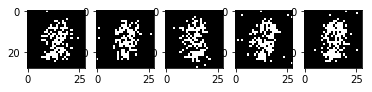

Iter: 110, DiscLoss: 0.971, GenLoss: 1.088, RealProb: 0.670, Fake Prob: 0.394, |DParam|: 16.598, |GParam|: 42.836, Temp: 0.9890
Iter: 120, DiscLoss: 0.971, GenLoss: 1.101, RealProb: 0.664, Fake Prob: 0.387, |DParam|: 16.730, |GParam|: 45.516, Temp: 0.9880
Iter: 130, DiscLoss: 0.974, GenLoss: 1.105, RealProb: 0.659, Fake Prob: 0.382, |DParam|: 16.845, |GParam|: 47.703, Temp: 0.9870
Iter: 140, DiscLoss: 0.973, GenLoss: 1.108, RealProb: 0.657, Fake Prob: 0.378, |DParam|: 16.943, |GParam|: 49.403, Temp: 0.9860
Iter: 150, DiscLoss: 0.970, GenLoss: 1.115, RealProb: 0.656, Fake Prob: 0.373, |DParam|: 17.031, |GParam|: 50.786, Temp: 0.9850
Iter: 160, DiscLoss: 0.964, GenLoss: 1.123, RealProb: 0.656, Fake Prob: 0.368, |DParam|: 17.113, |GParam|: 51.985, Temp: 0.9840
Iter: 170, DiscLoss: 0.958, GenLoss: 1.131, RealProb: 0.657, Fake Prob: 0.363, |DParam|: 17.190, |GParam|: 53.106, Temp: 0.9830
Iter: 180, DiscLoss: 0.957, GenLoss: 1.141, RealProb: 0.657, Fake Prob: 0.359, |DParam|: 17.260, |GParam

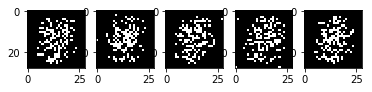

Iter: 210, DiscLoss: 0.924, GenLoss: 1.193, RealProb: 0.668, Fake Prob: 0.342, |DParam|: 17.468, |GParam|: 56.793, Temp: 0.9790
Iter: 220, DiscLoss: 0.907, GenLoss: 1.223, RealProb: 0.673, Fake Prob: 0.334, |DParam|: 17.536, |GParam|: 57.568, Temp: 0.9780
Iter: 230, DiscLoss: 0.889, GenLoss: 1.257, RealProb: 0.680, Fake Prob: 0.327, |DParam|: 17.607, |GParam|: 58.369, Temp: 0.9770
Iter: 240, DiscLoss: 0.871, GenLoss: 1.294, RealProb: 0.686, Fake Prob: 0.320, |DParam|: 17.676, |GParam|: 59.206, Temp: 0.9760
Iter: 250, DiscLoss: 0.850, GenLoss: 1.336, RealProb: 0.693, Fake Prob: 0.312, |DParam|: 17.744, |GParam|: 60.045, Temp: 0.9750
Iter: 260, DiscLoss: 0.830, GenLoss: 1.384, RealProb: 0.701, Fake Prob: 0.305, |DParam|: 17.812, |GParam|: 60.816, Temp: 0.9740
Iter: 270, DiscLoss: 0.809, GenLoss: 1.438, RealProb: 0.708, Fake Prob: 0.297, |DParam|: 17.876, |GParam|: 61.466, Temp: 0.9730
Iter: 280, DiscLoss: 0.789, GenLoss: 1.493, RealProb: 0.715, Fake Prob: 0.290, |DParam|: 17.936, |GParam

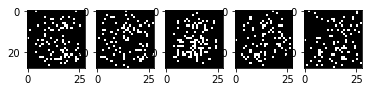

Iter: 310, DiscLoss: 0.753, GenLoss: 1.615, RealProb: 0.732, Fake Prob: 0.276, |DParam|: 18.136, |GParam|: 62.794, Temp: 0.9690
Iter: 320, DiscLoss: 0.743, GenLoss: 1.673, RealProb: 0.737, Fake Prob: 0.272, |DParam|: 18.216, |GParam|: 63.235, Temp: 0.9680
Iter: 330, DiscLoss: 0.738, GenLoss: 1.735, RealProb: 0.741, Fake Prob: 0.268, |DParam|: 18.278, |GParam|: 64.182, Temp: 0.9670
Iter: 340, DiscLoss: 0.733, GenLoss: 1.782, RealProb: 0.745, Fake Prob: 0.266, |DParam|: 18.329, |GParam|: 65.398, Temp: 0.9660
Iter: 350, DiscLoss: 0.723, GenLoss: 1.821, RealProb: 0.749, Fake Prob: 0.262, |DParam|: 18.378, |GParam|: 66.591, Temp: 0.9650
Iter: 360, DiscLoss: 0.714, GenLoss: 1.854, RealProb: 0.753, Fake Prob: 0.259, |DParam|: 18.424, |GParam|: 67.660, Temp: 0.9640
Iter: 370, DiscLoss: 0.708, GenLoss: 1.881, RealProb: 0.756, Fake Prob: 0.257, |DParam|: 18.465, |GParam|: 68.592, Temp: 0.9630
Iter: 380, DiscLoss: 0.707, GenLoss: 1.900, RealProb: 0.758, Fake Prob: 0.256, |DParam|: 18.493, |GParam

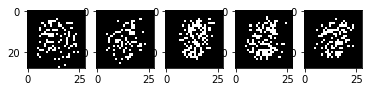

Iter: 410, DiscLoss: 0.697, GenLoss: 1.907, RealProb: 0.762, Fake Prob: 0.253, |DParam|: 18.602, |GParam|: 71.372, Temp: 0.9590
Iter: 420, DiscLoss: 0.688, GenLoss: 1.912, RealProb: 0.765, Fake Prob: 0.250, |DParam|: 18.654, |GParam|: 71.911, Temp: 0.9580
Iter: 430, DiscLoss: 0.679, GenLoss: 1.920, RealProb: 0.769, Fake Prob: 0.248, |DParam|: 18.699, |GParam|: 72.421, Temp: 0.9570
Iter: 440, DiscLoss: 0.671, GenLoss: 1.926, RealProb: 0.772, Fake Prob: 0.245, |DParam|: 18.737, |GParam|: 72.939, Temp: 0.9560
Iter: 450, DiscLoss: 0.663, GenLoss: 1.931, RealProb: 0.775, Fake Prob: 0.243, |DParam|: 18.775, |GParam|: 73.436, Temp: 0.9550
Iter: 460, DiscLoss: 0.656, GenLoss: 1.940, RealProb: 0.777, Fake Prob: 0.241, |DParam|: 18.810, |GParam|: 73.901, Temp: 0.9540
Iter: 470, DiscLoss: 0.649, GenLoss: 1.953, RealProb: 0.780, Fake Prob: 0.238, |DParam|: 18.843, |GParam|: 74.346, Temp: 0.9530
Iter: 480, DiscLoss: 0.641, GenLoss: 1.964, RealProb: 0.783, Fake Prob: 0.236, |DParam|: 18.876, |GParam

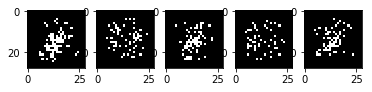

Iter: 510, DiscLoss: 0.624, GenLoss: 1.982, RealProb: 0.790, Fake Prob: 0.231, |DParam|: 18.961, |GParam|: 76.228, Temp: 0.9490
Iter: 520, DiscLoss: 0.618, GenLoss: 1.989, RealProb: 0.793, Fake Prob: 0.229, |DParam|: 18.987, |GParam|: 76.681, Temp: 0.9480
Iter: 530, DiscLoss: 0.612, GenLoss: 1.995, RealProb: 0.795, Fake Prob: 0.227, |DParam|: 19.015, |GParam|: 77.091, Temp: 0.9470
Iter: 540, DiscLoss: 0.606, GenLoss: 2.008, RealProb: 0.798, Fake Prob: 0.224, |DParam|: 19.040, |GParam|: 77.446, Temp: 0.9460
Iter: 550, DiscLoss: 0.600, GenLoss: 2.019, RealProb: 0.800, Fake Prob: 0.222, |DParam|: 19.067, |GParam|: 77.824, Temp: 0.9450
Iter: 560, DiscLoss: 0.593, GenLoss: 2.032, RealProb: 0.802, Fake Prob: 0.220, |DParam|: 19.098, |GParam|: 78.310, Temp: 0.9440
Iter: 570, DiscLoss: 0.587, GenLoss: 2.044, RealProb: 0.804, Fake Prob: 0.218, |DParam|: 19.130, |GParam|: 78.916, Temp: 0.9430
Iter: 580, DiscLoss: 0.581, GenLoss: 2.062, RealProb: 0.807, Fake Prob: 0.215, |DParam|: 19.160, |GParam

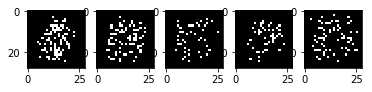

Iter: 610, DiscLoss: 0.563, GenLoss: 2.137, RealProb: 0.813, Fake Prob: 0.209, |DParam|: 19.232, |GParam|: 81.131, Temp: 0.9390
Iter: 620, DiscLoss: 0.556, GenLoss: 2.178, RealProb: 0.816, Fake Prob: 0.206, |DParam|: 19.256, |GParam|: 81.750, Temp: 0.9380
Iter: 630, DiscLoss: 0.548, GenLoss: 2.221, RealProb: 0.818, Fake Prob: 0.203, |DParam|: 19.277, |GParam|: 82.466, Temp: 0.9370
Iter: 640, DiscLoss: 0.542, GenLoss: 2.253, RealProb: 0.820, Fake Prob: 0.201, |DParam|: 19.296, |GParam|: 83.296, Temp: 0.9360
Iter: 650, DiscLoss: 0.539, GenLoss: 2.282, RealProb: 0.822, Fake Prob: 0.199, |DParam|: 19.315, |GParam|: 84.162, Temp: 0.9350
Iter: 660, DiscLoss: 0.536, GenLoss: 2.310, RealProb: 0.823, Fake Prob: 0.198, |DParam|: 19.344, |GParam|: 84.990, Temp: 0.9340
Iter: 670, DiscLoss: 0.531, GenLoss: 2.339, RealProb: 0.825, Fake Prob: 0.196, |DParam|: 19.384, |GParam|: 85.834, Temp: 0.9330
Iter: 680, DiscLoss: 0.527, GenLoss: 2.368, RealProb: 0.827, Fake Prob: 0.194, |DParam|: 19.421, |GParam

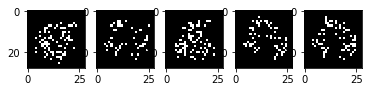

Iter: 710, DiscLoss: 0.512, GenLoss: 2.431, RealProb: 0.832, Fake Prob: 0.189, |DParam|: 19.519, |GParam|: 89.147, Temp: 0.9290
Iter: 720, DiscLoss: 0.507, GenLoss: 2.449, RealProb: 0.834, Fake Prob: 0.188, |DParam|: 19.546, |GParam|: 89.810, Temp: 0.9280
Iter: 730, DiscLoss: 0.504, GenLoss: 2.464, RealProb: 0.836, Fake Prob: 0.187, |DParam|: 19.569, |GParam|: 90.393, Temp: 0.9270
Iter: 740, DiscLoss: 0.501, GenLoss: 2.481, RealProb: 0.837, Fake Prob: 0.186, |DParam|: 19.584, |GParam|: 90.892, Temp: 0.9260
Iter: 750, DiscLoss: 0.498, GenLoss: 2.500, RealProb: 0.839, Fake Prob: 0.185, |DParam|: 19.595, |GParam|: 91.309, Temp: 0.9250
Iter: 760, DiscLoss: 0.494, GenLoss: 2.521, RealProb: 0.840, Fake Prob: 0.183, |DParam|: 19.608, |GParam|: 91.675, Temp: 0.9240
Iter: 770, DiscLoss: 0.490, GenLoss: 2.542, RealProb: 0.842, Fake Prob: 0.182, |DParam|: 19.621, |GParam|: 92.031, Temp: 0.9230
Iter: 780, DiscLoss: 0.487, GenLoss: 2.559, RealProb: 0.843, Fake Prob: 0.181, |DParam|: 19.635, |GParam

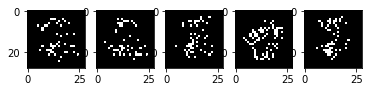

Iter: 810, DiscLoss: 0.477, GenLoss: 2.607, RealProb: 0.847, Fake Prob: 0.177, |DParam|: 19.676, |GParam|: 93.350, Temp: 0.9190
Iter: 820, DiscLoss: 0.475, GenLoss: 2.609, RealProb: 0.848, Fake Prob: 0.177, |DParam|: 19.685, |GParam|: 93.687, Temp: 0.9180
Iter: 830, DiscLoss: 0.477, GenLoss: 2.605, RealProb: 0.848, Fake Prob: 0.177, |DParam|: 19.689, |GParam|: 94.009, Temp: 0.9170
Iter: 840, DiscLoss: 0.476, GenLoss: 2.605, RealProb: 0.848, Fake Prob: 0.176, |DParam|: 19.698, |GParam|: 94.318, Temp: 0.9160
Iter: 850, DiscLoss: 0.474, GenLoss: 2.608, RealProb: 0.849, Fake Prob: 0.175, |DParam|: 19.714, |GParam|: 94.628, Temp: 0.9150
Iter: 860, DiscLoss: 0.472, GenLoss: 2.615, RealProb: 0.850, Fake Prob: 0.174, |DParam|: 19.730, |GParam|: 94.937, Temp: 0.9140
Iter: 870, DiscLoss: 0.469, GenLoss: 2.620, RealProb: 0.851, Fake Prob: 0.173, |DParam|: 19.742, |GParam|: 95.273, Temp: 0.9130
Iter: 880, DiscLoss: 0.466, GenLoss: 2.630, RealProb: 0.852, Fake Prob: 0.172, |DParam|: 19.756, |GParam

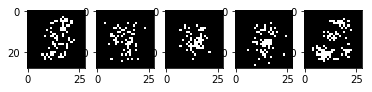

Iter: 910, DiscLoss: 0.463, GenLoss: 2.669, RealProb: 0.854, Fake Prob: 0.171, |DParam|: 19.793, |GParam|: 96.791, Temp: 0.9090
Iter: 920, DiscLoss: 0.462, GenLoss: 2.687, RealProb: 0.854, Fake Prob: 0.171, |DParam|: 19.809, |GParam|: 97.182, Temp: 0.9080
Iter: 930, DiscLoss: 0.460, GenLoss: 2.705, RealProb: 0.855, Fake Prob: 0.170, |DParam|: 19.825, |GParam|: 97.549, Temp: 0.9070
Iter: 940, DiscLoss: 0.457, GenLoss: 2.723, RealProb: 0.856, Fake Prob: 0.169, |DParam|: 19.843, |GParam|: 97.869, Temp: 0.9060
Iter: 950, DiscLoss: 0.455, GenLoss: 2.740, RealProb: 0.857, Fake Prob: 0.168, |DParam|: 19.855, |GParam|: 98.125, Temp: 0.9050
Iter: 960, DiscLoss: 0.452, GenLoss: 2.751, RealProb: 0.858, Fake Prob: 0.167, |DParam|: 19.865, |GParam|: 98.333, Temp: 0.9040
Iter: 970, DiscLoss: 0.450, GenLoss: 2.753, RealProb: 0.859, Fake Prob: 0.166, |DParam|: 19.876, |GParam|: 98.529, Temp: 0.9030
Iter: 980, DiscLoss: 0.448, GenLoss: 2.758, RealProb: 0.860, Fake Prob: 0.165, |DParam|: 19.887, |GParam

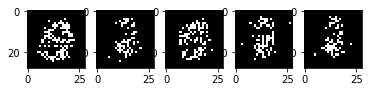

Iter: 1010, DiscLoss: 0.445, GenLoss: 2.789, RealProb: 0.861, Fake Prob: 0.164, |DParam|: 19.914, |GParam|: 99.234, Temp: 0.8990
Iter: 1020, DiscLoss: 0.445, GenLoss: 2.795, RealProb: 0.862, Fake Prob: 0.163, |DParam|: 19.932, |GParam|: 99.504, Temp: 0.8980
Iter: 1030, DiscLoss: 0.445, GenLoss: 2.802, RealProb: 0.862, Fake Prob: 0.163, |DParam|: 19.954, |GParam|: 99.922, Temp: 0.8970
Iter: 1040, DiscLoss: 0.444, GenLoss: 2.810, RealProb: 0.862, Fake Prob: 0.163, |DParam|: 19.976, |GParam|: 100.307, Temp: 0.8960
Iter: 1050, DiscLoss: 0.443, GenLoss: 2.822, RealProb: 0.863, Fake Prob: 0.162, |DParam|: 19.997, |GParam|: 100.683, Temp: 0.8950
Iter: 1060, DiscLoss: 0.442, GenLoss: 2.832, RealProb: 0.863, Fake Prob: 0.162, |DParam|: 20.013, |GParam|: 101.014, Temp: 0.8940
Iter: 1070, DiscLoss: 0.441, GenLoss: 2.839, RealProb: 0.864, Fake Prob: 0.161, |DParam|: 20.024, |GParam|: 101.286, Temp: 0.8930
Iter: 1080, DiscLoss: 0.441, GenLoss: 2.845, RealProb: 0.864, Fake Prob: 0.161, |DParam|: 20.

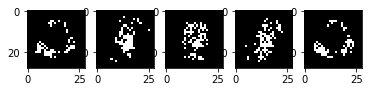

Iter: 1110, DiscLoss: 0.442, GenLoss: 2.845, RealProb: 0.864, Fake Prob: 0.160, |DParam|: 20.049, |GParam|: 102.334, Temp: 0.8890
Iter: 1120, DiscLoss: 0.442, GenLoss: 2.845, RealProb: 0.865, Fake Prob: 0.160, |DParam|: 20.060, |GParam|: 102.539, Temp: 0.8880
Iter: 1130, DiscLoss: 0.441, GenLoss: 2.844, RealProb: 0.865, Fake Prob: 0.160, |DParam|: 20.071, |GParam|: 102.731, Temp: 0.8870
Iter: 1140, DiscLoss: 0.441, GenLoss: 2.844, RealProb: 0.865, Fake Prob: 0.159, |DParam|: 20.081, |GParam|: 102.945, Temp: 0.8860
Iter: 1150, DiscLoss: 0.441, GenLoss: 2.847, RealProb: 0.865, Fake Prob: 0.159, |DParam|: 20.091, |GParam|: 103.186, Temp: 0.8850
Iter: 1160, DiscLoss: 0.442, GenLoss: 2.845, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.098, |GParam|: 103.415, Temp: 0.8840
Iter: 1170, DiscLoss: 0.443, GenLoss: 2.843, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.105, |GParam|: 103.598, Temp: 0.8830
Iter: 1180, DiscLoss: 0.444, GenLoss: 2.844, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 

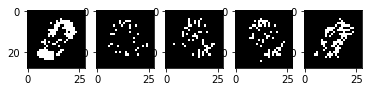

Iter: 1210, DiscLoss: 0.446, GenLoss: 2.849, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.117, |GParam|: 104.182, Temp: 0.8790
Iter: 1220, DiscLoss: 0.446, GenLoss: 2.849, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.126, |GParam|: 104.332, Temp: 0.8780
Iter: 1230, DiscLoss: 0.446, GenLoss: 2.848, RealProb: 0.867, Fake Prob: 0.159, |DParam|: 20.143, |GParam|: 104.507, Temp: 0.8770
Iter: 1240, DiscLoss: 0.447, GenLoss: 2.845, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.161, |GParam|: 104.759, Temp: 0.8760
Iter: 1250, DiscLoss: 0.449, GenLoss: 2.840, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.172, |GParam|: 105.162, Temp: 0.8750
Iter: 1260, DiscLoss: 0.451, GenLoss: 2.835, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 20.185, |GParam|: 105.551, Temp: 0.8740
Iter: 1270, DiscLoss: 0.451, GenLoss: 2.829, RealProb: 0.865, Fake Prob: 0.159, |DParam|: 20.203, |GParam|: 105.833, Temp: 0.8730
Iter: 1280, DiscLoss: 0.451, GenLoss: 2.827, RealProb: 0.866, Fake Prob: 0.159, |DParam|: 

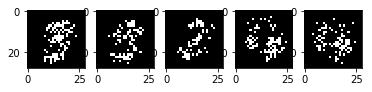

Iter: 1310, DiscLoss: 0.450, GenLoss: 2.820, RealProb: 0.866, Fake Prob: 0.158, |DParam|: 20.265, |GParam|: 106.489, Temp: 0.8690
Iter: 1320, DiscLoss: 0.450, GenLoss: 2.818, RealProb: 0.866, Fake Prob: 0.158, |DParam|: 20.282, |GParam|: 106.638, Temp: 0.8680
Iter: 1330, DiscLoss: 0.449, GenLoss: 2.818, RealProb: 0.867, Fake Prob: 0.157, |DParam|: 20.300, |GParam|: 106.806, Temp: 0.8670
Iter: 1340, DiscLoss: 0.448, GenLoss: 2.820, RealProb: 0.867, Fake Prob: 0.157, |DParam|: 20.320, |GParam|: 106.996, Temp: 0.8660
Iter: 1350, DiscLoss: 0.446, GenLoss: 2.821, RealProb: 0.867, Fake Prob: 0.156, |DParam|: 20.341, |GParam|: 107.208, Temp: 0.8650
Iter: 1360, DiscLoss: 0.444, GenLoss: 2.822, RealProb: 0.868, Fake Prob: 0.156, |DParam|: 20.364, |GParam|: 107.409, Temp: 0.8640
Iter: 1370, DiscLoss: 0.443, GenLoss: 2.820, RealProb: 0.868, Fake Prob: 0.155, |DParam|: 20.385, |GParam|: 107.596, Temp: 0.8630
Iter: 1380, DiscLoss: 0.442, GenLoss: 2.819, RealProb: 0.869, Fake Prob: 0.155, |DParam|: 

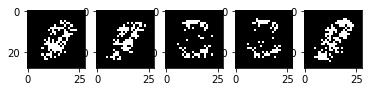

Iter: 1410, DiscLoss: 0.441, GenLoss: 2.815, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.448, |GParam|: 108.155, Temp: 0.8590
Iter: 1420, DiscLoss: 0.441, GenLoss: 2.813, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.456, |GParam|: 108.264, Temp: 0.8580
Iter: 1430, DiscLoss: 0.441, GenLoss: 2.812, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.463, |GParam|: 108.373, Temp: 0.8570
Iter: 1440, DiscLoss: 0.442, GenLoss: 2.809, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.468, |GParam|: 108.478, Temp: 0.8560
Iter: 1450, DiscLoss: 0.442, GenLoss: 2.810, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.468, |GParam|: 108.578, Temp: 0.8550
Iter: 1460, DiscLoss: 0.442, GenLoss: 2.811, RealProb: 0.869, Fake Prob: 0.154, |DParam|: 20.473, |GParam|: 108.682, Temp: 0.8540
Iter: 1470, DiscLoss: 0.442, GenLoss: 2.811, RealProb: 0.869, Fake Prob: 0.153, |DParam|: 20.484, |GParam|: 108.796, Temp: 0.8530
Iter: 1480, DiscLoss: 0.442, GenLoss: 2.808, RealProb: 0.869, Fake Prob: 0.153, |DParam|: 

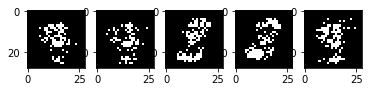

Iter: 1510, DiscLoss: 0.443, GenLoss: 2.801, RealProb: 0.869, Fake Prob: 0.153, |DParam|: 20.527, |GParam|: 109.301, Temp: 0.8490
Iter: 1520, DiscLoss: 0.442, GenLoss: 2.800, RealProb: 0.869, Fake Prob: 0.153, |DParam|: 20.545, |GParam|: 109.552, Temp: 0.8480
Iter: 1530, DiscLoss: 0.441, GenLoss: 2.801, RealProb: 0.870, Fake Prob: 0.152, |DParam|: 20.563, |GParam|: 109.899, Temp: 0.8470
Iter: 1540, DiscLoss: 0.440, GenLoss: 2.803, RealProb: 0.870, Fake Prob: 0.152, |DParam|: 20.582, |GParam|: 110.338, Temp: 0.8460
Iter: 1550, DiscLoss: 0.440, GenLoss: 2.802, RealProb: 0.870, Fake Prob: 0.152, |DParam|: 20.599, |GParam|: 110.690, Temp: 0.8450
Iter: 1560, DiscLoss: 0.440, GenLoss: 2.801, RealProb: 0.870, Fake Prob: 0.152, |DParam|: 20.616, |GParam|: 110.912, Temp: 0.8440
Iter: 1570, DiscLoss: 0.440, GenLoss: 2.799, RealProb: 0.870, Fake Prob: 0.151, |DParam|: 20.633, |GParam|: 111.064, Temp: 0.8430
Iter: 1580, DiscLoss: 0.439, GenLoss: 2.799, RealProb: 0.870, Fake Prob: 0.151, |DParam|: 

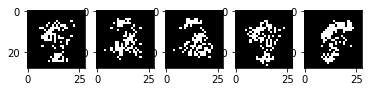

Iter: 1610, DiscLoss: 0.438, GenLoss: 2.797, RealProb: 0.871, Fake Prob: 0.150, |DParam|: 20.692, |GParam|: 111.506, Temp: 0.8390
Iter: 1620, DiscLoss: 0.438, GenLoss: 2.798, RealProb: 0.871, Fake Prob: 0.150, |DParam|: 20.703, |GParam|: 111.620, Temp: 0.8380
Iter: 1630, DiscLoss: 0.438, GenLoss: 2.799, RealProb: 0.871, Fake Prob: 0.150, |DParam|: 20.710, |GParam|: 111.722, Temp: 0.8370
Iter: 1640, DiscLoss: 0.437, GenLoss: 2.799, RealProb: 0.871, Fake Prob: 0.149, |DParam|: 20.720, |GParam|: 111.807, Temp: 0.8360
Iter: 1650, DiscLoss: 0.436, GenLoss: 2.800, RealProb: 0.871, Fake Prob: 0.149, |DParam|: 20.731, |GParam|: 111.889, Temp: 0.8350
Iter: 1660, DiscLoss: 0.437, GenLoss: 2.798, RealProb: 0.871, Fake Prob: 0.149, |DParam|: 20.740, |GParam|: 111.982, Temp: 0.8340
Iter: 1670, DiscLoss: 0.437, GenLoss: 2.796, RealProb: 0.871, Fake Prob: 0.149, |DParam|: 20.748, |GParam|: 112.078, Temp: 0.8330
Iter: 1680, DiscLoss: 0.437, GenLoss: 2.795, RealProb: 0.871, Fake Prob: 0.149, |DParam|: 

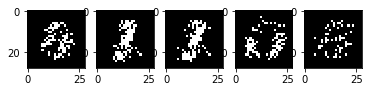

Iter: 1710, DiscLoss: 0.435, GenLoss: 2.793, RealProb: 0.871, Fake Prob: 0.148, |DParam|: 20.785, |GParam|: 112.398, Temp: 0.8290
Iter: 1720, DiscLoss: 0.435, GenLoss: 2.794, RealProb: 0.871, Fake Prob: 0.148, |DParam|: 20.797, |GParam|: 112.480, Temp: 0.8280
Iter: 1730, DiscLoss: 0.434, GenLoss: 2.793, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.808, |GParam|: 112.564, Temp: 0.8270
Iter: 1740, DiscLoss: 0.434, GenLoss: 2.793, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.819, |GParam|: 112.649, Temp: 0.8260
Iter: 1750, DiscLoss: 0.435, GenLoss: 2.791, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.825, |GParam|: 112.731, Temp: 0.8250
Iter: 1760, DiscLoss: 0.435, GenLoss: 2.790, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.833, |GParam|: 112.814, Temp: 0.8240
Iter: 1770, DiscLoss: 0.435, GenLoss: 2.788, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.845, |GParam|: 112.900, Temp: 0.8230
Iter: 1780, DiscLoss: 0.435, GenLoss: 2.784, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 

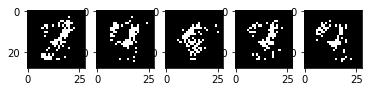

Iter: 1810, DiscLoss: 0.437, GenLoss: 2.773, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.908, |GParam|: 113.292, Temp: 0.8190
Iter: 1820, DiscLoss: 0.436, GenLoss: 2.771, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.922, |GParam|: 113.369, Temp: 0.8180
Iter: 1830, DiscLoss: 0.437, GenLoss: 2.768, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.935, |GParam|: 113.453, Temp: 0.8170
Iter: 1840, DiscLoss: 0.438, GenLoss: 2.765, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 20.944, |GParam|: 113.549, Temp: 0.8160
Iter: 1850, DiscLoss: 0.439, GenLoss: 2.762, RealProb: 0.870, Fake Prob: 0.148, |DParam|: 20.945, |GParam|: 113.647, Temp: 0.8150
Iter: 1860, DiscLoss: 0.440, GenLoss: 2.758, RealProb: 0.870, Fake Prob: 0.148, |DParam|: 20.954, |GParam|: 113.723, Temp: 0.8140
Iter: 1870, DiscLoss: 0.439, GenLoss: 2.755, RealProb: 0.870, Fake Prob: 0.148, |DParam|: 20.971, |GParam|: 113.797, Temp: 0.8130
Iter: 1880, DiscLoss: 0.439, GenLoss: 2.753, RealProb: 0.870, Fake Prob: 0.147, |DParam|: 

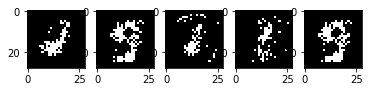

Iter: 1910, DiscLoss: 0.437, GenLoss: 2.752, RealProb: 0.871, Fake Prob: 0.147, |DParam|: 21.041, |GParam|: 114.129, Temp: 0.8090
Iter: 1920, DiscLoss: 0.437, GenLoss: 2.751, RealProb: 0.871, Fake Prob: 0.146, |DParam|: 21.058, |GParam|: 114.205, Temp: 0.8080
Iter: 1930, DiscLoss: 0.437, GenLoss: 2.750, RealProb: 0.871, Fake Prob: 0.146, |DParam|: 21.072, |GParam|: 114.293, Temp: 0.8070
Iter: 1940, DiscLoss: 0.436, GenLoss: 2.749, RealProb: 0.871, Fake Prob: 0.146, |DParam|: 21.088, |GParam|: 114.399, Temp: 0.8060
Iter: 1950, DiscLoss: 0.436, GenLoss: 2.750, RealProb: 0.871, Fake Prob: 0.146, |DParam|: 21.103, |GParam|: 114.515, Temp: 0.8050
Iter: 1960, DiscLoss: 0.435, GenLoss: 2.752, RealProb: 0.871, Fake Prob: 0.146, |DParam|: 21.117, |GParam|: 114.714, Temp: 0.8040
Iter: 1970, DiscLoss: 0.435, GenLoss: 2.754, RealProb: 0.871, Fake Prob: 0.145, |DParam|: 21.127, |GParam|: 115.019, Temp: 0.8030
Iter: 1980, DiscLoss: 0.435, GenLoss: 2.754, RealProb: 0.871, Fake Prob: 0.145, |DParam|: 

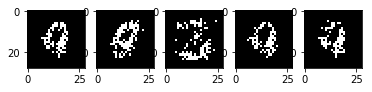

Iter: 2010, DiscLoss: 0.436, GenLoss: 2.751, RealProb: 0.871, Fake Prob: 0.145, |DParam|: 21.190, |GParam|: 116.437, Temp: 0.7990
Iter: 2020, DiscLoss: 0.435, GenLoss: 2.749, RealProb: 0.871, Fake Prob: 0.145, |DParam|: 21.203, |GParam|: 116.549, Temp: 0.7980
Iter: 2030, DiscLoss: 0.435, GenLoss: 2.748, RealProb: 0.872, Fake Prob: 0.145, |DParam|: 21.215, |GParam|: 116.646, Temp: 0.7970
Iter: 2040, DiscLoss: 0.434, GenLoss: 2.748, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 21.227, |GParam|: 116.735, Temp: 0.7960
Iter: 2050, DiscLoss: 0.434, GenLoss: 2.749, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 21.234, |GParam|: 116.809, Temp: 0.7950
Iter: 2060, DiscLoss: 0.434, GenLoss: 2.750, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 21.242, |GParam|: 116.886, Temp: 0.7940
Iter: 2070, DiscLoss: 0.433, GenLoss: 2.749, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 21.253, |GParam|: 116.990, Temp: 0.7930
Iter: 2080, DiscLoss: 0.434, GenLoss: 2.748, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 

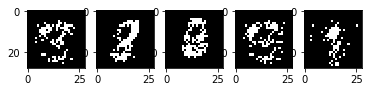

Iter: 2110, DiscLoss: 0.434, GenLoss: 2.743, RealProb: 0.872, Fake Prob: 0.144, |DParam|: 21.307, |GParam|: 117.672, Temp: 0.7890
Iter: 2120, DiscLoss: 0.435, GenLoss: 2.741, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.314, |GParam|: 117.780, Temp: 0.7880
Iter: 2130, DiscLoss: 0.435, GenLoss: 2.739, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.320, |GParam|: 117.867, Temp: 0.7870
Iter: 2140, DiscLoss: 0.435, GenLoss: 2.736, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.330, |GParam|: 117.940, Temp: 0.7860
Iter: 2150, DiscLoss: 0.436, GenLoss: 2.734, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.340, |GParam|: 118.006, Temp: 0.7850
Iter: 2160, DiscLoss: 0.436, GenLoss: 2.732, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.348, |GParam|: 118.068, Temp: 0.7840
Iter: 2170, DiscLoss: 0.436, GenLoss: 2.729, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.354, |GParam|: 118.133, Temp: 0.7830
Iter: 2180, DiscLoss: 0.437, GenLoss: 2.726, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 

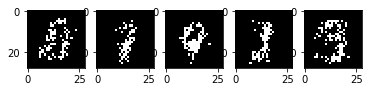

Iter: 2210, DiscLoss: 0.436, GenLoss: 2.721, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.401, |GParam|: 118.408, Temp: 0.7790
Iter: 2220, DiscLoss: 0.436, GenLoss: 2.720, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.413, |GParam|: 118.481, Temp: 0.7780
Iter: 2230, DiscLoss: 0.436, GenLoss: 2.719, RealProb: 0.871, Fake Prob: 0.144, |DParam|: 21.424, |GParam|: 118.565, Temp: 0.7770
Iter: 2240, DiscLoss: 0.436, GenLoss: 2.719, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.432, |GParam|: 118.653, Temp: 0.7760
Iter: 2250, DiscLoss: 0.436, GenLoss: 2.718, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.439, |GParam|: 118.749, Temp: 0.7750
Iter: 2260, DiscLoss: 0.436, GenLoss: 2.717, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.449, |GParam|: 118.851, Temp: 0.7740
Iter: 2270, DiscLoss: 0.437, GenLoss: 2.716, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.453, |GParam|: 118.949, Temp: 0.7730
Iter: 2280, DiscLoss: 0.437, GenLoss: 2.715, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 

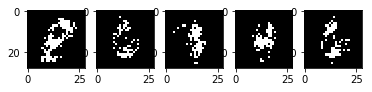

Iter: 2310, DiscLoss: 0.438, GenLoss: 2.710, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.482, |GParam|: 119.257, Temp: 0.7690
Iter: 2320, DiscLoss: 0.438, GenLoss: 2.708, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.493, |GParam|: 119.322, Temp: 0.7680
Iter: 2330, DiscLoss: 0.437, GenLoss: 2.706, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.506, |GParam|: 119.381, Temp: 0.7670
Iter: 2340, DiscLoss: 0.437, GenLoss: 2.705, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.519, |GParam|: 119.439, Temp: 0.7660
Iter: 2350, DiscLoss: 0.437, GenLoss: 2.703, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.529, |GParam|: 119.494, Temp: 0.7650
Iter: 2360, DiscLoss: 0.437, GenLoss: 2.701, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.540, |GParam|: 119.548, Temp: 0.7640
Iter: 2370, DiscLoss: 0.437, GenLoss: 2.700, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.551, |GParam|: 119.603, Temp: 0.7630
Iter: 2380, DiscLoss: 0.437, GenLoss: 2.698, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 

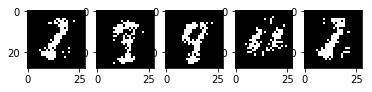

Iter: 2410, DiscLoss: 0.438, GenLoss: 2.694, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.595, |GParam|: 119.862, Temp: 0.7590
Iter: 2420, DiscLoss: 0.438, GenLoss: 2.692, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.611, |GParam|: 119.929, Temp: 0.7580
Iter: 2430, DiscLoss: 0.438, GenLoss: 2.691, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.626, |GParam|: 120.006, Temp: 0.7570
Iter: 2440, DiscLoss: 0.438, GenLoss: 2.690, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.636, |GParam|: 120.090, Temp: 0.7560
Iter: 2450, DiscLoss: 0.438, GenLoss: 2.689, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.646, |GParam|: 120.173, Temp: 0.7550
Iter: 2460, DiscLoss: 0.438, GenLoss: 2.688, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.656, |GParam|: 120.259, Temp: 0.7540
Iter: 2470, DiscLoss: 0.438, GenLoss: 2.688, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.668, |GParam|: 120.340, Temp: 0.7530
Iter: 2480, DiscLoss: 0.438, GenLoss: 2.687, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 

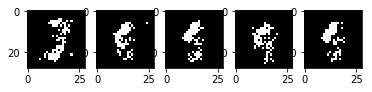

Iter: 2510, DiscLoss: 0.439, GenLoss: 2.684, RealProb: 0.871, Fake Prob: 0.143, |DParam|: 21.696, |GParam|: 120.661, Temp: 0.7490
Iter: 2520, DiscLoss: 0.439, GenLoss: 2.683, RealProb: 0.870, Fake Prob: 0.143, |DParam|: 21.704, |GParam|: 120.780, Temp: 0.7480
Iter: 2530, DiscLoss: 0.440, GenLoss: 2.682, RealProb: 0.870, Fake Prob: 0.143, |DParam|: 21.712, |GParam|: 120.895, Temp: 0.7470
Iter: 2540, DiscLoss: 0.441, GenLoss: 2.680, RealProb: 0.870, Fake Prob: 0.143, |DParam|: 21.717, |GParam|: 121.006, Temp: 0.7460
Iter: 2550, DiscLoss: 0.441, GenLoss: 2.678, RealProb: 0.870, Fake Prob: 0.143, |DParam|: 21.723, |GParam|: 121.098, Temp: 0.7450
Iter: 2560, DiscLoss: 0.442, GenLoss: 2.675, RealProb: 0.870, Fake Prob: 0.143, |DParam|: 21.728, |GParam|: 121.173, Temp: 0.7440
Iter: 2570, DiscLoss: 0.443, GenLoss: 2.673, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.737, |GParam|: 121.237, Temp: 0.7430
Iter: 2580, DiscLoss: 0.443, GenLoss: 2.670, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 

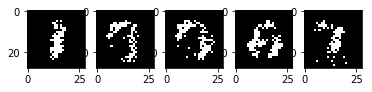

Iter: 2610, DiscLoss: 0.444, GenLoss: 2.665, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.773, |GParam|: 121.461, Temp: 0.7390
Iter: 2620, DiscLoss: 0.444, GenLoss: 2.663, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.784, |GParam|: 121.519, Temp: 0.7380
Iter: 2630, DiscLoss: 0.444, GenLoss: 2.661, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.796, |GParam|: 121.578, Temp: 0.7370
Iter: 2640, DiscLoss: 0.444, GenLoss: 2.659, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.809, |GParam|: 121.636, Temp: 0.7360
Iter: 2650, DiscLoss: 0.444, GenLoss: 2.658, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.819, |GParam|: 121.693, Temp: 0.7350
Iter: 2660, DiscLoss: 0.444, GenLoss: 2.658, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.829, |GParam|: 121.746, Temp: 0.7340
Iter: 2670, DiscLoss: 0.444, GenLoss: 2.656, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.842, |GParam|: 121.798, Temp: 0.7330
Iter: 2680, DiscLoss: 0.444, GenLoss: 2.654, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 

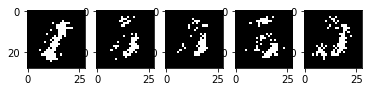

Iter: 2710, DiscLoss: 0.445, GenLoss: 2.649, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.880, |GParam|: 122.007, Temp: 0.7290
Iter: 2720, DiscLoss: 0.445, GenLoss: 2.648, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.888, |GParam|: 122.053, Temp: 0.7280
Iter: 2730, DiscLoss: 0.445, GenLoss: 2.646, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.898, |GParam|: 122.099, Temp: 0.7270
Iter: 2740, DiscLoss: 0.445, GenLoss: 2.644, RealProb: 0.869, Fake Prob: 0.143, |DParam|: 21.906, |GParam|: 122.152, Temp: 0.7260
Iter: 2750, DiscLoss: 0.446, GenLoss: 2.642, RealProb: 0.869, Fake Prob: 0.144, |DParam|: 21.911, |GParam|: 122.213, Temp: 0.7250
Iter: 2760, DiscLoss: 0.447, GenLoss: 2.640, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.916, |GParam|: 122.274, Temp: 0.7240
Iter: 2770, DiscLoss: 0.447, GenLoss: 2.638, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.925, |GParam|: 122.331, Temp: 0.7230
Iter: 2780, DiscLoss: 0.447, GenLoss: 2.636, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 

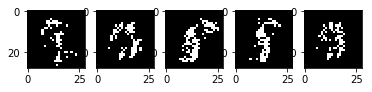

Iter: 2810, DiscLoss: 0.448, GenLoss: 2.632, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.962, |GParam|: 122.552, Temp: 0.7190
Iter: 2820, DiscLoss: 0.448, GenLoss: 2.629, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.968, |GParam|: 122.623, Temp: 0.7180
Iter: 2830, DiscLoss: 0.448, GenLoss: 2.627, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.978, |GParam|: 122.699, Temp: 0.7170
Iter: 2840, DiscLoss: 0.448, GenLoss: 2.626, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 21.991, |GParam|: 122.767, Temp: 0.7160
Iter: 2850, DiscLoss: 0.449, GenLoss: 2.625, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.001, |GParam|: 122.825, Temp: 0.7150
Iter: 2860, DiscLoss: 0.449, GenLoss: 2.623, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.012, |GParam|: 122.869, Temp: 0.7140
Iter: 2870, DiscLoss: 0.449, GenLoss: 2.622, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.023, |GParam|: 122.909, Temp: 0.7130
Iter: 2880, DiscLoss: 0.448, GenLoss: 2.620, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 

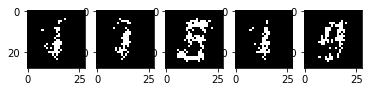

Iter: 2910, DiscLoss: 0.448, GenLoss: 2.617, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.061, |GParam|: 123.079, Temp: 0.7090
Iter: 2920, DiscLoss: 0.449, GenLoss: 2.616, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.065, |GParam|: 123.133, Temp: 0.7080
Iter: 2930, DiscLoss: 0.449, GenLoss: 2.615, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.069, |GParam|: 123.190, Temp: 0.7070
Iter: 2940, DiscLoss: 0.449, GenLoss: 2.614, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.076, |GParam|: 123.247, Temp: 0.7060
Iter: 2950, DiscLoss: 0.449, GenLoss: 2.613, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.084, |GParam|: 123.301, Temp: 0.7050
Iter: 2960, DiscLoss: 0.449, GenLoss: 2.612, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.095, |GParam|: 123.350, Temp: 0.7040
Iter: 2970, DiscLoss: 0.449, GenLoss: 2.612, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.105, |GParam|: 123.400, Temp: 0.7030
Iter: 2980, DiscLoss: 0.448, GenLoss: 2.612, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 

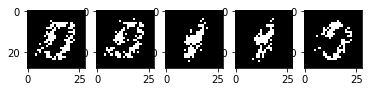

Iter: 3010, DiscLoss: 0.448, GenLoss: 2.610, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.146, |GParam|: 123.599, Temp: 0.6990
Iter: 3020, DiscLoss: 0.448, GenLoss: 2.609, RealProb: 0.868, Fake Prob: 0.144, |DParam|: 22.159, |GParam|: 123.651, Temp: 0.6980
Iter: 3030, DiscLoss: 0.448, GenLoss: 2.608, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.172, |GParam|: 123.704, Temp: 0.6970
Iter: 3040, DiscLoss: 0.448, GenLoss: 2.608, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.182, |GParam|: 123.758, Temp: 0.6960
Iter: 3050, DiscLoss: 0.447, GenLoss: 2.607, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.190, |GParam|: 123.813, Temp: 0.6950
Iter: 3060, DiscLoss: 0.447, GenLoss: 2.606, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.199, |GParam|: 123.869, Temp: 0.6940
Iter: 3070, DiscLoss: 0.448, GenLoss: 2.605, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.207, |GParam|: 123.923, Temp: 0.6930
Iter: 3080, DiscLoss: 0.448, GenLoss: 2.604, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 

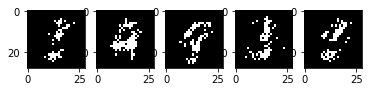

Iter: 3110, DiscLoss: 0.447, GenLoss: 2.602, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.241, |GParam|: 124.120, Temp: 0.6890
Iter: 3120, DiscLoss: 0.447, GenLoss: 2.601, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.247, |GParam|: 124.178, Temp: 0.6880
Iter: 3130, DiscLoss: 0.448, GenLoss: 2.600, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.250, |GParam|: 124.264, Temp: 0.6870
Iter: 3140, DiscLoss: 0.448, GenLoss: 2.600, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.255, |GParam|: 124.432, Temp: 0.6860
Iter: 3150, DiscLoss: 0.448, GenLoss: 2.599, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.274, |GParam|: 124.704, Temp: 0.6850
Iter: 3160, DiscLoss: 0.449, GenLoss: 2.598, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.331, |GParam|: 125.039, Temp: 0.6840
Iter: 3170, DiscLoss: 0.448, GenLoss: 2.598, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.382, |GParam|: 125.255, Temp: 0.6830
Iter: 3180, DiscLoss: 0.448, GenLoss: 2.597, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 

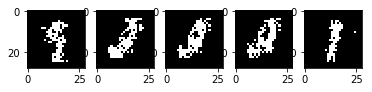

Iter: 3210, DiscLoss: 0.449, GenLoss: 2.596, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.437, |GParam|: 125.653, Temp: 0.6790
Iter: 3220, DiscLoss: 0.449, GenLoss: 2.596, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.448, |GParam|: 125.706, Temp: 0.6780
Iter: 3230, DiscLoss: 0.449, GenLoss: 2.595, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.459, |GParam|: 125.754, Temp: 0.6770
Iter: 3240, DiscLoss: 0.449, GenLoss: 2.595, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.471, |GParam|: 125.797, Temp: 0.6760
Iter: 3250, DiscLoss: 0.448, GenLoss: 2.595, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.481, |GParam|: 125.836, Temp: 0.6750
Iter: 3260, DiscLoss: 0.448, GenLoss: 2.594, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.491, |GParam|: 125.875, Temp: 0.6740
Iter: 3270, DiscLoss: 0.448, GenLoss: 2.593, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.501, |GParam|: 125.919, Temp: 0.6730
Iter: 3280, DiscLoss: 0.449, GenLoss: 2.591, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 

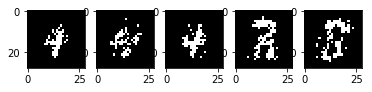

Iter: 3310, DiscLoss: 0.449, GenLoss: 2.590, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.532, |GParam|: 126.137, Temp: 0.6690
Iter: 3320, DiscLoss: 0.449, GenLoss: 2.589, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.541, |GParam|: 126.185, Temp: 0.6680
Iter: 3330, DiscLoss: 0.449, GenLoss: 2.589, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.550, |GParam|: 126.234, Temp: 0.6670
Iter: 3340, DiscLoss: 0.449, GenLoss: 2.588, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.556, |GParam|: 126.288, Temp: 0.6660
Iter: 3350, DiscLoss: 0.449, GenLoss: 2.589, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.557, |GParam|: 126.346, Temp: 0.6650
Iter: 3360, DiscLoss: 0.449, GenLoss: 2.588, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.560, |GParam|: 126.405, Temp: 0.6640
Iter: 3370, DiscLoss: 0.449, GenLoss: 2.588, RealProb: 0.868, Fake Prob: 0.143, |DParam|: 22.563, |GParam|: 126.466, Temp: 0.6630
Iter: 3380, DiscLoss: 0.449, GenLoss: 2.587, RealProb: 0.868, Fake Prob: 0.142, |DParam|: 

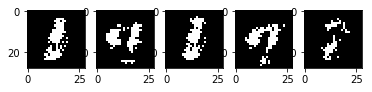

Iter: 3410, DiscLoss: 0.451, GenLoss: 2.583, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.578, |GParam|: 126.727, Temp: 0.6590
Iter: 3420, DiscLoss: 0.451, GenLoss: 2.581, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.588, |GParam|: 126.776, Temp: 0.6580
Iter: 3430, DiscLoss: 0.451, GenLoss: 2.579, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.597, |GParam|: 126.820, Temp: 0.6570
Iter: 3440, DiscLoss: 0.451, GenLoss: 2.578, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.605, |GParam|: 126.860, Temp: 0.6560
Iter: 3450, DiscLoss: 0.451, GenLoss: 2.576, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.613, |GParam|: 126.901, Temp: 0.6550
Iter: 3460, DiscLoss: 0.452, GenLoss: 2.575, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.620, |GParam|: 126.945, Temp: 0.6540
Iter: 3470, DiscLoss: 0.451, GenLoss: 2.573, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.629, |GParam|: 126.986, Temp: 0.6530
Iter: 3480, DiscLoss: 0.451, GenLoss: 2.572, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 

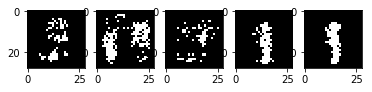

Iter: 3510, DiscLoss: 0.452, GenLoss: 2.570, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.658, |GParam|: 127.277, Temp: 0.6490
Iter: 3520, DiscLoss: 0.453, GenLoss: 2.569, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.661, |GParam|: 127.365, Temp: 0.6480
Iter: 3530, DiscLoss: 0.453, GenLoss: 2.567, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.666, |GParam|: 127.430, Temp: 0.6470
Iter: 3540, DiscLoss: 0.453, GenLoss: 2.566, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.674, |GParam|: 127.487, Temp: 0.6460
Iter: 3550, DiscLoss: 0.453, GenLoss: 2.564, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.686, |GParam|: 127.531, Temp: 0.6450
Iter: 3560, DiscLoss: 0.453, GenLoss: 2.564, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.697, |GParam|: 127.571, Temp: 0.6440
Iter: 3570, DiscLoss: 0.453, GenLoss: 2.563, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.706, |GParam|: 127.610, Temp: 0.6430
Iter: 3580, DiscLoss: 0.454, GenLoss: 2.561, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 

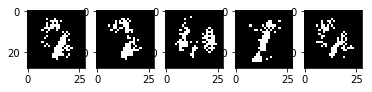

Iter: 3610, DiscLoss: 0.453, GenLoss: 2.559, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.739, |GParam|: 127.795, Temp: 0.6390
Iter: 3620, DiscLoss: 0.453, GenLoss: 2.559, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 22.752, |GParam|: 127.843, Temp: 0.6380
Iter: 3630, DiscLoss: 0.453, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.764, |GParam|: 127.886, Temp: 0.6370
Iter: 3640, DiscLoss: 0.453, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.776, |GParam|: 127.928, Temp: 0.6360
Iter: 3650, DiscLoss: 0.452, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.789, |GParam|: 127.969, Temp: 0.6350
Iter: 3660, DiscLoss: 0.452, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.801, |GParam|: 128.010, Temp: 0.6340
Iter: 3670, DiscLoss: 0.452, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.812, |GParam|: 128.060, Temp: 0.6330
Iter: 3680, DiscLoss: 0.452, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 

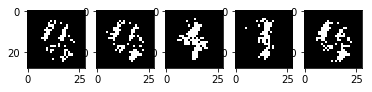

Iter: 3710, DiscLoss: 0.452, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.143, |DParam|: 22.843, |GParam|: 128.267, Temp: 0.6290
Iter: 3720, DiscLoss: 0.452, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.853, |GParam|: 128.317, Temp: 0.6280
Iter: 3730, DiscLoss: 0.451, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.864, |GParam|: 128.369, Temp: 0.6270
Iter: 3740, DiscLoss: 0.451, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.877, |GParam|: 128.424, Temp: 0.6260
Iter: 3750, DiscLoss: 0.450, GenLoss: 2.561, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.888, |GParam|: 128.478, Temp: 0.6250
Iter: 3760, DiscLoss: 0.450, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.895, |GParam|: 128.535, Temp: 0.6240
Iter: 3770, DiscLoss: 0.450, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.899, |GParam|: 128.597, Temp: 0.6230
Iter: 3780, DiscLoss: 0.450, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

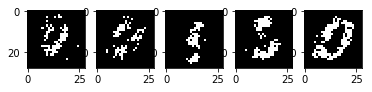

Iter: 3810, DiscLoss: 0.450, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.918, |GParam|: 128.839, Temp: 0.6190
Iter: 3820, DiscLoss: 0.450, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.927, |GParam|: 128.893, Temp: 0.6180
Iter: 3830, DiscLoss: 0.451, GenLoss: 2.562, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.934, |GParam|: 128.950, Temp: 0.6170
Iter: 3840, DiscLoss: 0.451, GenLoss: 2.561, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.942, |GParam|: 129.004, Temp: 0.6160
Iter: 3850, DiscLoss: 0.451, GenLoss: 2.561, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.952, |GParam|: 129.055, Temp: 0.6150
Iter: 3860, DiscLoss: 0.451, GenLoss: 2.560, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.959, |GParam|: 129.105, Temp: 0.6140
Iter: 3870, DiscLoss: 0.451, GenLoss: 2.559, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 22.968, |GParam|: 129.152, Temp: 0.6130
Iter: 3880, DiscLoss: 0.450, GenLoss: 2.558, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

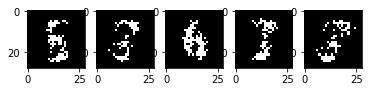

Iter: 3910, DiscLoss: 0.451, GenLoss: 2.556, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.003, |GParam|: 129.334, Temp: 0.6090
Iter: 3920, DiscLoss: 0.451, GenLoss: 2.555, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.002, |GParam|: 129.382, Temp: 0.6080
Iter: 3930, DiscLoss: 0.451, GenLoss: 2.554, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.004, |GParam|: 129.429, Temp: 0.6070
Iter: 3940, DiscLoss: 0.452, GenLoss: 2.554, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.009, |GParam|: 129.474, Temp: 0.6060
Iter: 3950, DiscLoss: 0.452, GenLoss: 2.552, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.017, |GParam|: 129.517, Temp: 0.6050
Iter: 3960, DiscLoss: 0.452, GenLoss: 2.551, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.028, |GParam|: 129.558, Temp: 0.6040
Iter: 3970, DiscLoss: 0.451, GenLoss: 2.550, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.041, |GParam|: 129.595, Temp: 0.6030
Iter: 3980, DiscLoss: 0.451, GenLoss: 2.550, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

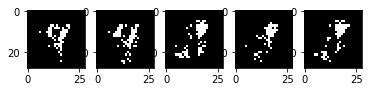

Iter: 4010, DiscLoss: 0.451, GenLoss: 2.550, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.081, |GParam|: 129.755, Temp: 0.5990
Iter: 4020, DiscLoss: 0.451, GenLoss: 2.550, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.088, |GParam|: 129.814, Temp: 0.5980
Iter: 4030, DiscLoss: 0.450, GenLoss: 2.551, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.096, |GParam|: 129.888, Temp: 0.5970
Iter: 4040, DiscLoss: 0.450, GenLoss: 2.551, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.104, |GParam|: 129.981, Temp: 0.5960
Iter: 4050, DiscLoss: 0.451, GenLoss: 2.551, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.112, |GParam|: 130.149, Temp: 0.5950
Iter: 4060, DiscLoss: 0.451, GenLoss: 2.551, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.114, |GParam|: 130.324, Temp: 0.5940
Iter: 4070, DiscLoss: 0.451, GenLoss: 2.550, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.119, |GParam|: 130.445, Temp: 0.5930
Iter: 4080, DiscLoss: 0.452, GenLoss: 2.549, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

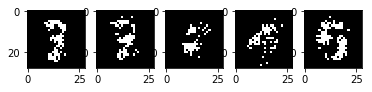

Iter: 4110, DiscLoss: 0.452, GenLoss: 2.546, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.150, |GParam|: 130.657, Temp: 0.5890
Iter: 4120, DiscLoss: 0.452, GenLoss: 2.545, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.158, |GParam|: 130.700, Temp: 0.5880
Iter: 4130, DiscLoss: 0.452, GenLoss: 2.545, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.166, |GParam|: 130.744, Temp: 0.5870
Iter: 4140, DiscLoss: 0.452, GenLoss: 2.544, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.174, |GParam|: 130.790, Temp: 0.5860
Iter: 4150, DiscLoss: 0.453, GenLoss: 2.543, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.181, |GParam|: 130.835, Temp: 0.5850
Iter: 4160, DiscLoss: 0.453, GenLoss: 2.542, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.185, |GParam|: 130.879, Temp: 0.5840
Iter: 4170, DiscLoss: 0.453, GenLoss: 2.541, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.188, |GParam|: 130.921, Temp: 0.5830
Iter: 4180, DiscLoss: 0.453, GenLoss: 2.540, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

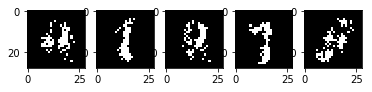

Iter: 4210, DiscLoss: 0.453, GenLoss: 2.539, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.222, |GParam|: 131.115, Temp: 0.5790
Iter: 4220, DiscLoss: 0.453, GenLoss: 2.538, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.231, |GParam|: 131.178, Temp: 0.5780
Iter: 4230, DiscLoss: 0.453, GenLoss: 2.537, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.243, |GParam|: 131.237, Temp: 0.5770
Iter: 4240, DiscLoss: 0.453, GenLoss: 2.537, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.255, |GParam|: 131.291, Temp: 0.5760
Iter: 4250, DiscLoss: 0.453, GenLoss: 2.537, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.263, |GParam|: 131.351, Temp: 0.5750
Iter: 4260, DiscLoss: 0.453, GenLoss: 2.537, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.269, |GParam|: 131.428, Temp: 0.5740
Iter: 4270, DiscLoss: 0.453, GenLoss: 2.536, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.275, |GParam|: 131.518, Temp: 0.5730
Iter: 4280, DiscLoss: 0.453, GenLoss: 2.536, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 

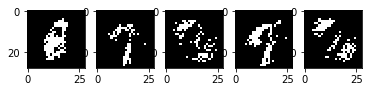

Iter: 4310, DiscLoss: 0.453, GenLoss: 2.534, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.305, |GParam|: 131.762, Temp: 0.5690
Iter: 4320, DiscLoss: 0.454, GenLoss: 2.533, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.309, |GParam|: 131.811, Temp: 0.5680
Iter: 4330, DiscLoss: 0.454, GenLoss: 2.532, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.312, |GParam|: 131.854, Temp: 0.5670
Iter: 4340, DiscLoss: 0.454, GenLoss: 2.531, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.319, |GParam|: 131.893, Temp: 0.5660
Iter: 4350, DiscLoss: 0.455, GenLoss: 2.530, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.328, |GParam|: 131.926, Temp: 0.5650
Iter: 4360, DiscLoss: 0.454, GenLoss: 2.529, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.338, |GParam|: 131.957, Temp: 0.5640
Iter: 4370, DiscLoss: 0.455, GenLoss: 2.528, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.347, |GParam|: 131.991, Temp: 0.5630
Iter: 4380, DiscLoss: 0.455, GenLoss: 2.526, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 

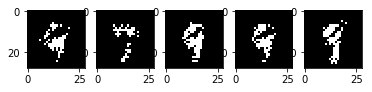

Iter: 4410, DiscLoss: 0.456, GenLoss: 2.523, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.370, |GParam|: 132.153, Temp: 0.5590
Iter: 4420, DiscLoss: 0.456, GenLoss: 2.522, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.380, |GParam|: 132.191, Temp: 0.5580
Iter: 4430, DiscLoss: 0.456, GenLoss: 2.521, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.392, |GParam|: 132.229, Temp: 0.5570
Iter: 4440, DiscLoss: 0.456, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 23.403, |GParam|: 132.268, Temp: 0.5560
Iter: 4450, DiscLoss: 0.456, GenLoss: 2.519, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 23.415, |GParam|: 132.307, Temp: 0.5550
Iter: 4460, DiscLoss: 0.456, GenLoss: 2.518, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 23.426, |GParam|: 132.346, Temp: 0.5540
Iter: 4470, DiscLoss: 0.456, GenLoss: 2.518, RealProb: 0.866, Fake Prob: 0.143, |DParam|: 23.438, |GParam|: 132.383, Temp: 0.5530
Iter: 4480, DiscLoss: 0.456, GenLoss: 2.517, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 

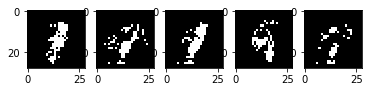

Iter: 4510, DiscLoss: 0.455, GenLoss: 2.518, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.488, |GParam|: 132.530, Temp: 0.5490
Iter: 4520, DiscLoss: 0.455, GenLoss: 2.519, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.496, |GParam|: 132.571, Temp: 0.5480
Iter: 4530, DiscLoss: 0.455, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.503, |GParam|: 132.611, Temp: 0.5470
Iter: 4540, DiscLoss: 0.454, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.511, |GParam|: 132.650, Temp: 0.5460
Iter: 4550, DiscLoss: 0.454, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.517, |GParam|: 132.694, Temp: 0.5450
Iter: 4560, DiscLoss: 0.454, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.521, |GParam|: 132.742, Temp: 0.5440
Iter: 4570, DiscLoss: 0.454, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 23.528, |GParam|: 132.788, Temp: 0.5430
Iter: 4580, DiscLoss: 0.454, GenLoss: 2.520, RealProb: 0.866, Fake Prob: 0.142, |DParam|: 

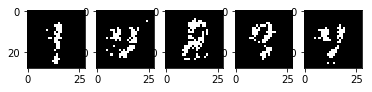

Iter: 4610, DiscLoss: 0.453, GenLoss: 2.520, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.563, |GParam|: 132.950, Temp: 0.5390
Iter: 4620, DiscLoss: 0.453, GenLoss: 2.520, RealProb: 0.867, Fake Prob: 0.142, |DParam|: 23.573, |GParam|: 132.995, Temp: 0.5380
Iter: 4630, DiscLoss: 0.453, GenLoss: 2.521, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.583, |GParam|: 133.045, Temp: 0.5370
Iter: 4640, DiscLoss: 0.453, GenLoss: 2.521, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.590, |GParam|: 133.096, Temp: 0.5360
Iter: 4650, DiscLoss: 0.452, GenLoss: 2.522, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.597, |GParam|: 133.148, Temp: 0.5350
Iter: 4660, DiscLoss: 0.452, GenLoss: 2.522, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.604, |GParam|: 133.200, Temp: 0.5340
Iter: 4670, DiscLoss: 0.452, GenLoss: 2.522, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.611, |GParam|: 133.258, Temp: 0.5330
Iter: 4680, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 

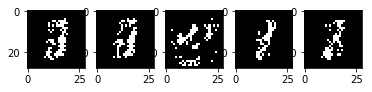

Iter: 4710, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.615, |GParam|: 133.649, Temp: 0.5290
Iter: 4720, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.630, |GParam|: 133.907, Temp: 0.5280
Iter: 4730, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.648, |GParam|: 134.188, Temp: 0.5270
Iter: 4740, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.662, |GParam|: 134.335, Temp: 0.5260
Iter: 4750, DiscLoss: 0.452, GenLoss: 2.524, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.669, |GParam|: 134.421, Temp: 0.5250
Iter: 4760, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.675, |GParam|: 134.478, Temp: 0.5240
Iter: 4770, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.682, |GParam|: 134.520, Temp: 0.5230
Iter: 4780, DiscLoss: 0.452, GenLoss: 2.523, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 

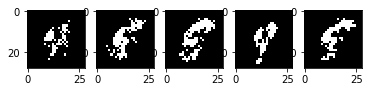

Iter: 4810, DiscLoss: 0.453, GenLoss: 2.522, RealProb: 0.867, Fake Prob: 0.141, |DParam|: 23.698, |GParam|: 134.696, Temp: 0.5190


KeyboardInterrupt: 

In [122]:
plt.rcParams['figure.figsize'] = 6, 6
latent_dim = 32
lr = 0.0002
epochs = 100
temp = 1.
D = nn.Sequential(nn.Linear(784, 512), nn.LeakyReLU(0.2),
                  nn.Linear(512, 256), nn.LeakyReLU(0.2),
                  nn.Linear(256, 128), nn.LeakyReLU(0.2),                  
                  nn.Linear(128, 1), nn.Sigmoid())
G = nn.Sequential(nn.Linear(latent_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.2),
                    nn.Linear(128, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2),
                     nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2),
                     nn.Linear(512, 784))

for p in list(D.parameters()) + list(G.parameters()):
    p.data.normal_(0, 0.02)
    
D_optim = torch.optim.Adam(D.parameters(), lr = 0.0001)
G_optim = torch.optim.Adam(G.parameters(), lr = 0.0005)

avg_D_loss = 0
avg_G_loss = 0
avg_real_prob = 0
avg_fake_prob = 0
eps = 1e-5
i = 0
for epoch in range(epochs):
    for datum in train_loader:
        i += 1
        temp = max(0.001, temp - 0.0001)
        img, _ = datum
        real = torch.autograd.Variable(img.view(img.size(0), -1).float())
        z = torch.autograd.Variable(torch.randn(BATCH_SIZE, latent_dim).uniform_(-1, 1))         
        u = torch.autograd.Variable(torch.zeros(BATCH_SIZE, 784).uniform_(0, 1))
        l = u.log() + (1-u).log()        
        fake = G(z)
        fake = F.sigmoid((fake + l)/temp)
        real_prob = torch.clamp(D(real), min = eps, max = 1-eps)
        fake_prob = torch.clamp(D(fake), min = eps, max = 1-eps)
        D_loss = -(real_prob.log().mean() + (1-fake_prob).log().mean())
        D_optim.zero_grad()                
        D_loss.backward(retain_graph=True)
        D_optim.step()

        G_optim.zero_grad()        
        G_loss = -fake_prob.log().mean()
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        
        avg_real_prob += real_prob.data.mean()
        avg_fake_prob += fake_prob.data.mean()
        avg_D_loss += D_loss.data[0]
        avg_G_loss += G_loss.data[0]
        D_param = sum([p.data.norm()**2 for p in D.parameters()])**0.5
        G_param = sum([p.data.norm()**2 for p in G.parameters()])**0.5
        
        if i % 10 == 0:
            print(("Iter: %d, DiscLoss: %.3f, GenLoss: %.3f, RealProb: %.3f, Fake Prob: %.3f, |DParam|: %.3f, |GParam|: %.3f, Temp: %.4f") %
                 (i, avg_D_loss/i, avg_G_loss/i, avg_real_prob/i, avg_fake_prob/i, D_param, G_param, temp))
            if i % 100 == 0:
                f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
                fake = torch.bernoulli(torch.clamp(fake, min=eps, max = 1-eps))
                ax1.imshow(fake[0].data.view(28,28).numpy(), cmap='gray')
                ax2.imshow(fake[1].data.view(28,28).numpy(), cmap='gray')
                ax3.imshow(fake[2].data.view(28,28).numpy(), cmap='gray')
                ax4.imshow(fake[3].data.view(28,28).numpy(), cmap='gray')
                ax5.imshow(fake[4].data.view(28,28).numpy(), cmap='gray')            
                plt.show()

            